In [ ]:
pip install formulaic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 1.2 MB/s eta 0:00:00


In [2]:
from formulaic import Formula

In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [87]:
datos = pd.read_csv('sube-2023.csv')

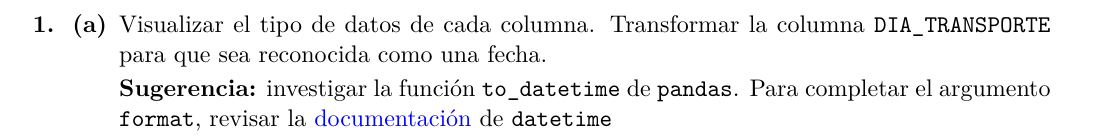

In [88]:
# Convertimos a la columna DIA_TRANSPORTE para que sea reconocida a como una fecha
datos['DIA_TRANSPORTE'] = pd.to_datetime(datos['DIA_TRANSPORTE'], format='%Y-%m-%d')

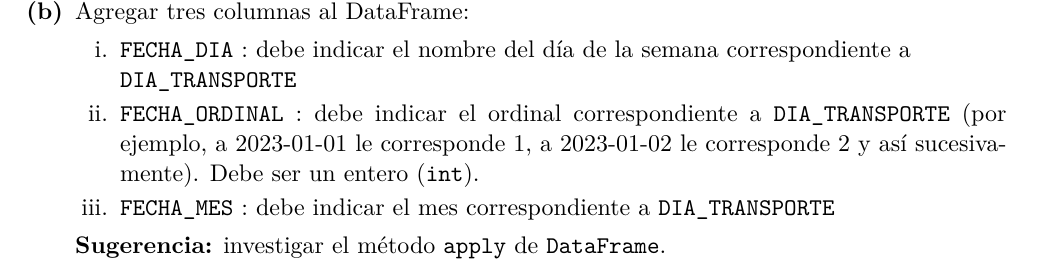

In [89]:
# Agregamos a nuestra DataFrame las columnas indicadas

# Agregamos la columna de fecha_dia con el formato observado en el ejemplo, solamente con 3 carácteres
datos['fecha_dia'] = datos['DIA_TRANSPORTE'].dt.day_name().str[:3]
# Agregamos la columna de fecha_mes en formato 'MM', 2 dígitos para el mes
datos['fecha_mes'] = datos['DIA_TRANSPORTE'].dt.strftime('%m')
# Agregamos la columna de fecha_ordinal indicando el día ordinal del año
datos['fecha_ordinal'] = datos['DIA_TRANSPORTE'].dt.dayofyear

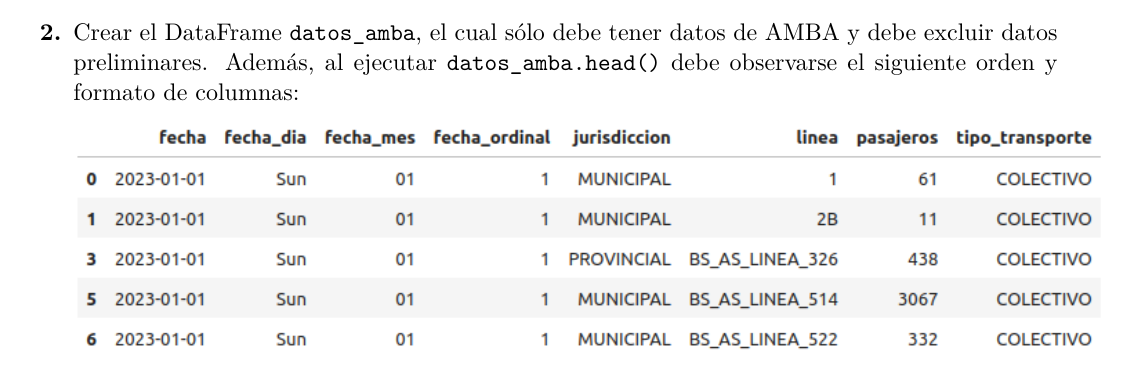

In [90]:
#Creamos un nuevo data frame con los valores a trabajar solicitados.
datos_filtrados = datos[(datos['AMBA'] == 'SI') & (datos['DATO_PRELIMINAR'] == "NO")]

In [91]:
datos_filtrados.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,fecha_dia,fecha_mes,fecha_ordinal
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO,Sun,01,1
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO,Sun,01,1
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO,Sun,01,1
5,2023-01-01,AUTOBUSES BUENOS AIRES S.R.L. – TRANSPORTE LAR...,BS_AS_LINEA_514,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,ALMIRANTE BROWN,3067,NO,Sun,01,1
6,2023-01-01,EL URBANO SRL,BS_AS_LINEA_522,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,LANUS,332,NO,Sun,01,1


In [9]:
#Seleccionamos las columnas correspondientes a visualizar.
column_order  = ['DIA_TRANSPORTE', 'fecha_dia', 'fecha_mes', 'fecha_ordinal', 'JURISDICCION', 'LINEA', 'CANTIDAD', 'TIPO_TRANSPORTE']
datos_filtrados = datos_filtrados[column_order]

In [10]:
#Renombramos las columnas correspondientes y colocamos el formato correcto.
datos_filtrados = datos_filtrados.rename(columns = {"DIA_TRANSPORTE" : "fecha", "CANTIDAD" : "pasajeros"})
#Renombramos las columnas en un formato que sea minúsculas
datos_amba = datos_filtrados.rename(columns = str.lower)

In [11]:
#Visualizamos lo pedido
datos_amba.head()

,fecha,fecha_dia,fecha_mes,fecha_ordinal,jurisdiccion,linea,pasajeros,tipo_transporte
0,2023-01-01,Sun,01,1,MUNICIPAL,1,61,COLECTIVO
1,2023-01-01,Sun,01,1,MUNICIPAL,2B,11,COLECTIVO
3,2023-01-01,Sun,01,1,PROVINCIAL,BS_AS_LINEA_326,438,COLECTIVO
5,2023-01-01,Sun,01,1,MUNICIPAL,BS_AS_LINEA_514,3067,COLECTIVO
6,2023-01-01,Sun,01,1,MUNICIPAL,BS_AS_LINEA_522,332,COLECTIVO


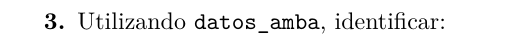

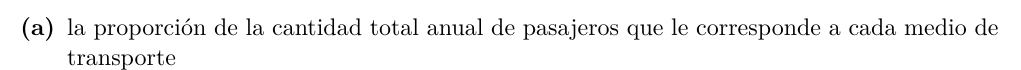

In [12]:
#Realizamos el agrupamiento correspondiente por tipo de transporte y pasajeros, calculando así su proporción
proporcion_transporte = datos_amba.groupby('tipo_transporte')['pasajeros'].sum() / datos_amba['pasajeros'].sum()
print(proporcion_transporte)

tipo_transporte
COLECTIVO    0.837645
SUBTE        0.068097
TREN         0.094258
Name: pasajeros, dtype: float64


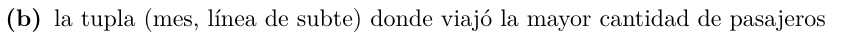

In [13]:
#Creamos un nuevo dataFrame donde sólo estén los datos del tipo de transporte "SUBTE" que se encuentran en el AMBA
subte_data = datos_amba[(datos_amba['tipo_transporte'] == 'SUBTE')]

In [14]:
#Realizamos las tuplas indicadas y sumamos la cantidad de pasajeros, según el mes y la línea
pasajeros_subte_mes = subte_data.groupby(['fecha_mes','linea'])['pasajeros'].sum()
#Localizamos la tupla con el valor máximo en cantidad de pasajeros
max_pasajeros_subte = pasajeros_subte_mes.idxmax()
#Nos quedamos con el valor que posee la mayor cantidad de pasajeros
max_value = pasajeros_subte_mes.max()
#Imprimimos el mes donde concurrió en el SUBTE la mayor cantidad de pasajeros
print(f"El mes con la mayor cantidad de pasajeros fue: {max_pasajeros_subte[0]}")
#Imprimimos la línea donde concurrió en el SUBTE la mayor cantidad de pasajeros
print(f"La línea de subte que tuvo la mayor cantidad de pasajeros fue : {max_pasajeros_subte[1]}")
#Imprimimos el valor máximo que hubo en cantidad de pasajeros
print(max_value)
#Imprimimos la tupla corresponidente indicada
print(max_pasajeros_subte)


El mes con la mayor cantidad de pasajeros fue: 08
La línea de subte que tuvo la mayor cantidad de pasajeros fue : LINEA_B
5227906
('08', 'LINEA_B')


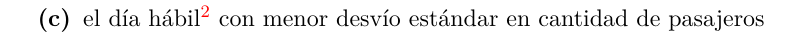

In [15]:
#Realizamos un nuevo DataFrame con los días hábiles a analizar.
días_hábiles = datos_amba[datos_amba['fecha_dia'].isin(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])]
#Realizamos un agrupamiento por días y utilizamos la función std para calcular el desvío entandar en cada día.
desvio_hábiles = días_hábiles.groupby('fecha_dia')['pasajeros'].std()
#Nos quedamos con el valor mínimo.
dia_menor_desvio = desvio_hábiles.idxmin()
print(f"EL día hábil que posee el menor desvío estándar es: {dia_menor_desvio}")

EL día hábil que posee el menor desvío estándar es: Mon


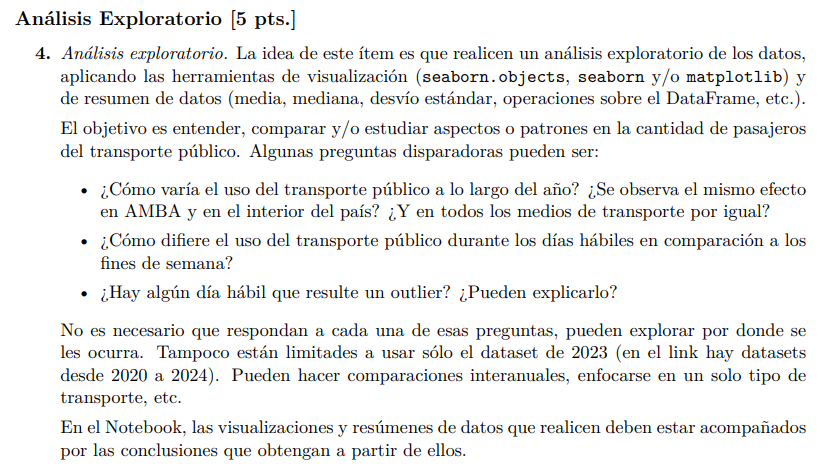

In [18]:
df_2020 = pd.read_csv('dat-ab-usos-2020.csv')
df_2021 = pd.read_csv('dat-ab-usos-2021.csv')
df_2022 = pd.read_csv('dat-ab-usos-2022.csv')
df_2023 = pd.read_csv('sube-2023.csv')


# Concateno los DataFrames y genero uno nuevo unificado
df_all_years_basic = pd.concat([df_2020, df_2021, df_2022, df_2023], ignore_index=True)

# Guardar el DataFrame unificado en un nuevo archivo CSV para poder descagarlo
output_path = 'sube_2020_2023_basic.csv'
df_all_years_basic.to_csv(output_path, index=False)

output_path

'sube_2020_2023_basic.csv'

In [25]:
#normalizo y limpio el dataFrame

# Convertimos a la columna DIA_TRANSPORTE para que sea reconocida a como una fecha
df_all_years = df_all_years_basic.copy()
df_all_years['DIA_TRANSPORTE'] = pd.to_datetime(df_all_years_basic['DIA_TRANSPORTE'], format='%Y-%m-%d')

In [26]:
# Agregamos a nuestra DataFrame las columnas correspondiente a tiempos

df_all_years['fecha_dia'] = df_all_years['DIA_TRANSPORTE'].dt.day_name().str[:3]
df_all_years['fecha_mes'] = df_all_years['DIA_TRANSPORTE'].dt.strftime('%m')
df_all_years['fecha_ordinal'] = df_all_years['DIA_TRANSPORTE'].dt.dayofyear
df_all_years['año'] = df_all_years['DIA_TRANSPORTE'].dt.year

In [27]:
#Renombro para normalizar y coloco todo en minusculas
df_all_years = df_all_years.rename(columns = {"DIA_TRANSPORTE" : "fecha", "CANTIDAD" : "pasajeros"})
df_all_years = df_all_years.rename(columns = str.lower)


In [33]:
#Descargo la base limpia con todos los años y normalizada
output_path = 'sube_2020_2023.csv'
df_all_years.to_csv(output_path, index=False)

output_path

'sube_2020_2023.csv'

In [40]:
#Trabajo sobre los datos del AMBA
datos_ambas_completos = df_all_years[(df_all_years['amba'] == 'SI') & (df_all_years['dato_preliminar'] == "NO")]


In [41]:
datos_ambas_completos.head()

,fecha,nombre_empresa,linea,amba,tipo_transporte,jurisdiccion,provincia,municipio,pasajeros,dato_preliminar,fecha_dia,fecha_mes,fecha_ordinal,año
1,2020-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,1492,NO,Wed,01,1,2020
3,2020-01-01,AUTOBUSES BUENOS AIRES S.R.L. – TRANSPORTE LAR...,BS_AS_LINEA_514,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,ALMIRANTE BROWN,4669,NO,Wed,01,1,2020
4,2020-01-01,EL URBANO SRL,BS_AS_LINEA_522,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,LANUS,187,NO,Wed,01,1,2020
5,2020-01-01,EL URBANO SRL,BS_AS_LINEA_527,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,LANUS,543,NO,Wed,01,1,2020
6,2020-01-01,TRANSPORTES LINEA 123 S.A.C.I.,BS_ASLINEA_123,SI,COLECTIVO,NACIONAL,JN,SD,1927,NO,Wed,01,1,2020


¿Cuál es el medio más utilizado?

In [56]:
# Proporción de tipo de transporte
proporcion_transporte = datos_ambas_completos.groupby('tipo_transporte')['pasajeros'].sum().reset_index()
proporcion_transporte

,tipo_transporte,pasajeros
0,COLECTIVO,9040615838
1,SUBTE,632157513
2,TREN,1008547039


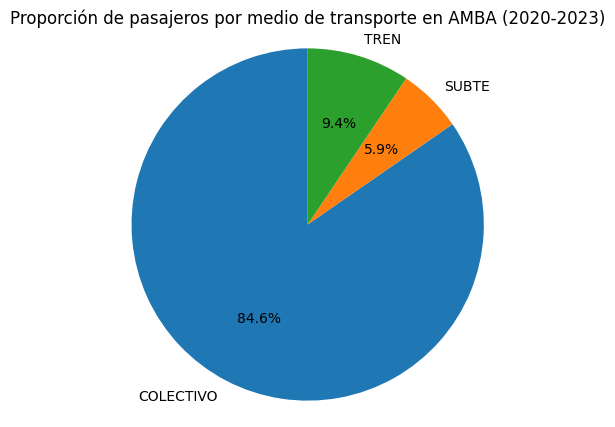

In [45]:
plt.figure(figsize=(5, 5))
plt.pie(proporcion_transporte['pasajeros'], labels=proporcion_transporte['tipo_transporte'], autopct='%1.1f%%', startangle=90)
plt.title('Proporción de pasajeros por medio de transporte en AMBA (2020-2023)')
plt.axis('equal')  # Asegura que el gráfico sea un círculo
plt.show()

¿Cuántas líneas posee cada tipo de transporte?

In [57]:

lineas_por_transporte_amba = datos_ambas_completos.groupby('tipo_transporte')['linea'].nunique().reset_index()
lineas_por_transporte_amba.columns = ['tipo_transporte', 'cantidad']

In [58]:
# proporción de cada tipo de transporte
total_lineas_amba = lineas_por_transporte_amba['cantidad'].sum()
lineas_por_transporte_amba['proporcion'] = lineas_por_transporte_amba['cantidad'] / total_lineas_amba
lineas_por_transporte_amba

,tipo_transporte,cantidad,proporcion
0,COLECTIVO,399,0.941038
1,SUBTE,7,0.016509
2,TREN,18,0.042453


¿Cúales son las empresas que poseen la mayor cantidad de pasajeros a nivel colectivos?

In [72]:
colectivos = datos_ambas_completos[datos_ambas_completos["tipo_transporte"] == "COLECTIVO"]

In [74]:
colectivos.head()

,fecha,nombre_empresa,linea,amba,tipo_transporte,jurisdiccion,provincia,municipio,pasajeros,dato_preliminar,fecha_dia,fecha_mes,fecha_ordinal,año
1,2020-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,1492,NO,Wed,01,1,2020
3,2020-01-01,AUTOBUSES BUENOS AIRES S.R.L. – TRANSPORTE LAR...,BS_AS_LINEA_514,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,ALMIRANTE BROWN,4669,NO,Wed,01,1,2020
4,2020-01-01,EL URBANO SRL,BS_AS_LINEA_522,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,LANUS,187,NO,Wed,01,1,2020
5,2020-01-01,EL URBANO SRL,BS_AS_LINEA_527,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,LANUS,543,NO,Wed,01,1,2020
6,2020-01-01,TRANSPORTES LINEA 123 S.A.C.I.,BS_ASLINEA_123,SI,COLECTIVO,NACIONAL,JN,SD,1927,NO,Wed,01,1,2020


In [120]:
pasajeros_por_empresa = colectivos.groupby('nombre_empresa')['pasajeros'].sum().reset_index()
pasajeros_por_empresa = pasajeros_por_empresa.sort_values(by='pasajeros', ascending=False)
pasajeros_por_empresa

,nombre_empresa,pasajeros
139,TRANSPORTES LA PERLITA S.A.,296922553
40,EMPRESA LINEA 216 S.A.T.,279150546
64,LA CABAÑA S.A.,205093830
61,GENERAL TOMAS GUIDO S.A.C.I.F.,187605442
68,LA NUEVA METROPOL S.A.,170077244
...,...,...
37,EMPRESA DE TRANSPORTES SANTA RITA SRL,1425964
115,SERGIO A. RIVAS S.R.L,949970
103,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,683165
19,COOPERATIVA DE TRABAJO 3 DE JULIO LIMITADA,528443


In [121]:
lineas_por_empresa = colectivos.groupby('nombre_empresa')['linea'].nunique().reset_index()
lineas_por_empresa = lineas_por_empresa.sort_values(by='linea', ascending=False)
lineas_por_empresa

,nombre_empresa,linea
161,ZARATE TRANSPORTE S.A.P.E.M.,12
113,SAN VICENTE S.A. DE TRANSPORTES,11
38,EMPRESA DEL OESTE SAT,10
146,TRANSPORTES SAN JUAN BAUTISTA S.A.,10
97,MICRO OMNIBUS TIGRE S.A.,10
...,...,...
96,MICRO OMNIBUS SUR S.A.C.,1
37,EMPRESA DE TRANSPORTES SANTA RITA SRL,1
93,MICRO OMNIBUS O´HIGGINS S.A.T.,1
92,MICRO OMNIBUS NORTE S.A.,1


In [119]:
zonas_por_empresa = colectivos.groupby('nombre_empresa')['municipio'].nunique().reset_index()
municipios_por_empresa = zonas_por_empresa.sort_values(by='municipio', ascending=False)

# Mostrar el resultado
print(municipios_por_empresa)

                          nombre_empresa  municipio
40              EMPRESA LINEA 216 S.A.T.          5
95   MICRO OMNIBUS QUILMES S.A.C.I. Y F.          4
34     EMPRESA DE TRANSPORTE DEL SUR SRL          4
64                        LA CABAÑA S.A.          4
97              MICRO OMNIBUS TIGRE S.A.          4
..                                   ...        ...
53           EXPRESO NUEVE DE JULIO S.A.          1
52    EXPRESO LA PLATA BUENOS AIRES S.A.          1
50     EXPRESO ESTEBAN ECHEVERRIA S.R.L.          1
49          EXPRESO EMPALME LOBOS S.R.L.          1
161         ZARATE TRANSPORTE S.A.P.E.M.          1

[162 rows x 2 columns]


In [123]:
municipios_pasajeros = colectivos.groupby('municipio')['pasajeros'].sum().reset_index()
municipios_pasajeros = municipios_pasajeros.sort_values(by='pasajeros', ascending=False)

# Mostrar el resultado
print(municipios_pasajeros)

                municipio   pasajeros
33                     SD  4101817342
34                     SN  2935959775
15             LA MATANZA   211310714
19        LOMAS DE ZAMORA   193020768
0         ALMIRANTE BROWN   172737274
24                 MORENO   169291814
16               LA PLATA   149959035
23                  MERLO   148902467
35                  TIGRE   128438381
26                  PILAR   101497156
7      ESTEBAN ECHEVERRIA    86479673
28                QUILMES    75768510
14            JOSE C. PAZ    67633991
17                  LANUS    67549810
10       FLORENCIO VARELA    62884090
30             SAN ISIDRO    42164614
9                  EZEIZA    39259318
2             BERAZATEGUI    36009075
31             SAN MIGUEL    35950721
12     GENERAL SAN MARTIN    35634554
6                 ESCOBAR    34403514
25                  MORON    26713888
29           SAN FERNANDO    24588720
11      GENERAL RODRIGUEZ    23823613
20                  LUJAN    14166437
1           

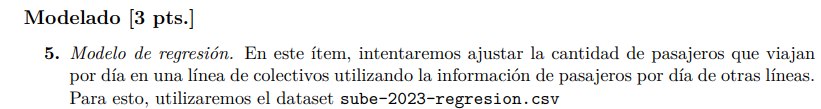

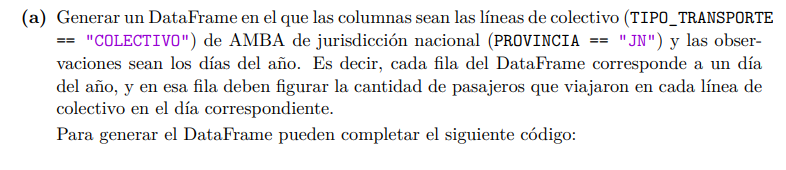

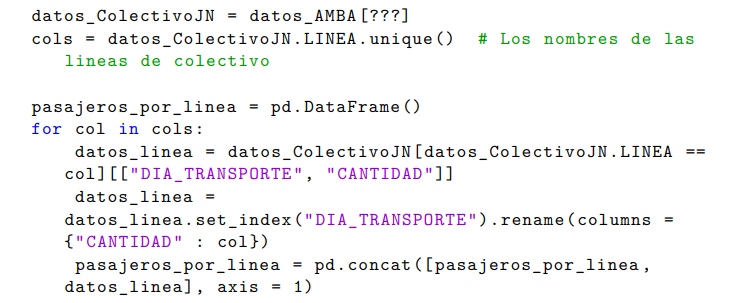

In [66]:
datos_regresion = pd.read_csv('sube-2023-regresion.csv')

In [67]:
datos_regresion.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO
2,2023-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1707,NO
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO
4,2023-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1189,NO


In [68]:
datos_ColectivoJN = datos_regresion[(datos_regresion['AMBA'] == 'SI') & (datos_regresion['PROVINCIA'] == 'JN') & (datos_regresion['TIPO_TRANSPORTE'] == 'COLECTIVO')]

In [69]:
cols = datos_ColectivoJN['LINEA'].unique()
pasajeros_por_linea = pd.DataFrame()

for col in cols:
    datos_linea = datos_ColectivoJN[datos_ColectivoJN['LINEA'] == col][['DIA_TRANSPORTE', 'CANTIDAD']]
    datos_linea = datos_linea.set_index('DIA_TRANSPORTE').rename(columns={'CANTIDAD': col})
    pasajeros_por_linea = pd.concat([pasajeros_por_linea, datos_linea], axis=1)


In [70]:
pasajeros_por_linea.head()

,BS_ASLINEA_123,BSAS_LINEA_002,BSAS_LINEA_009,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_019,BSAS_LINEA_020,BSAS_LINEA_021,BSAS_LINEA_022,...,LINEA 5,LINEA 50,LINEA 6,LINEA 7,LINEA 76,LINEA 8,LINEA_099,LINEA_119_AMBA,LINEA_164_AMBA,LINEA 119
DIA_TRANSPORTE,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1681,5670,5644,5177,9109,7013,1604,2617,11235,2202,...,4832.0,4839,2449,2184,3797,5317,1882,1573.0,3210,NaN
2023-01-02,9440,21759,23284,21176,45269,29962,13921,11934,55611,13823,...,20333.0,16221,10486,12774,17374,23250,10322,7345.0,19362,NaN
2023-01-04,10540,24755,25405,23806,52873,33659,16172,13366,61721,16206,...,23041.0,18448,12193,13949,19860,26294,11981,7925.0,21784,NaN
2023-01-05,10408,25772,26489,24688,53436,35182,16569,12929,62510,16863,...,23928.0,18481,12888,14668,21235,27216,11787,7597.0,22972,NaN
2023-01-06,10530,26021,26458,24167,53163,35212,16459,12955,63528,16846,...,24247.0,19300,12703,14199,23472,27073,11567,7811.0,23411,NaN


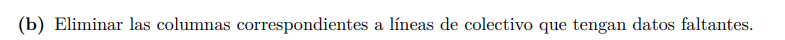

In [71]:
pasajeros_por_linea.isnull().values.any() #Este comando nos indica si hay valores nulos

True

In [72]:
# Eliminar las columnas con datos faltantes
pasajeros_por_linea = pasajeros_por_linea.dropna(axis = 1)

In [73]:
pasajeros_por_linea.isnull().values.any() #Este comando nos indica si hay valores nulos

False

In [74]:
pasajeros_por_linea.head()

,BS_ASLINEA_123,BSAS_LINEA_002,BSAS_LINEA_009,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_019,BSAS_LINEA_020,BSAS_LINEA_021,BSAS_LINEA_022,...,LINEA 4,LINEA 42,LINEA 44,LINEA 50,LINEA 6,LINEA 7,LINEA 76,LINEA 8,LINEA_099,LINEA_164_AMBA
DIA_TRANSPORTE,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1681,5670,5644,5177,9109,7013,1604,2617,11235,2202,...,2942,4029,4649,4839,2449,2184,3797,5317,1882,3210
2023-01-02,9440,21759,23284,21176,45269,29962,13921,11934,55611,13823,...,15329,19072,20387,16221,10486,12774,17374,23250,10322,19362
2023-01-04,10540,24755,25405,23806,52873,33659,16172,13366,61721,16206,...,17836,21609,23595,18448,12193,13949,19860,26294,11981,21784
2023-01-05,10408,25772,26489,24688,53436,35182,16569,12929,62510,16863,...,18044,21993,23687,18481,12888,14668,21235,27216,11787,22972
2023-01-06,10530,26021,26458,24167,53163,35212,16459,12955,63528,16846,...,18122,22421,23731,19300,12703,14199,23472,27073,11567,23411


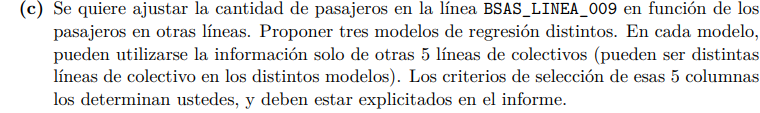